## AlexNet Model Training Porocess

### Import libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [2]:
train_path = 'split_data/train'
valid_path = 'split_data/val'
test_path = 'split_data/test'

### Training classes

In [3]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [4]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [5]:

# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 3161
Test samples: 657
Validation samples: 558


In [6]:
train_n = 3161
test_n = 657
valid_n = 558

### Training steps (per epoch)

In [7]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [8]:
epochs = 30

### Generate batches

In [9]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 3161 images belonging to 9 classes.
Found 558 images belonging to 9 classes.
Found 657 images belonging to 9 classes.


### Base model (AlexNet)

#### Training from scratch

In [10]:
base_model = tf.keras.applications.VGG16(include_top=False,
    weights=None,
    pooling='avg')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
output =  tf.keras.layers.Dense(len(train_classes), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

### Generate new model

In [14]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [15]:
history = new_model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/30
197/197 [==============================] - 474s 2s/step - loss: 2.1802 - accuracy: 0.1135 - val_loss: 2.1412 - val_accuracy: 0.1305
Epoch 2/30
197/197 [==============================] - 454s 2s/step - loss: 2.1067 - accuracy: 0.1984 - val_loss: 2.0837 - val_accuracy: 0.1397
Epoch 3/30
197/197 [==============================] - 454s 2s/step - loss: 2.0479 - accuracy: 0.2649 - val_loss: 2.0034 - val_accuracy: 0.3364
Epoch 4/30
197/197 [==============================] - 493s 3s/step - loss: 1.9836 - accuracy: 0.3507 - val_loss: 1.9697 - val_accuracy: 0.2206
Epoch 5/30
197/197 [==============================] - 524s 3s/step - loss: 1.9314 - accuracy: 0.3781 - val_loss: 1.9033 - val_accuracy: 0.3603
Epoch 6/30
197/197 [==============================] - 540s 3s/step - loss: 1.8765 - accuracy: 0.4429 - val_loss: 1.8575 - val_accuracy: 0.3787
Epoch 7/30
197/197 [==============================] - 525s 3s/step - loss: 1.8275 - accuracy: 0.5021 - val_loss: 1.7985 - val_accuracy: 0.4393

### Evaluate training process

In [16]:
results = new_model.evaluate_generator(train_batches, train_steps)
results

[1.5671069622039795, 0.6234136819839478]

#### Loss function

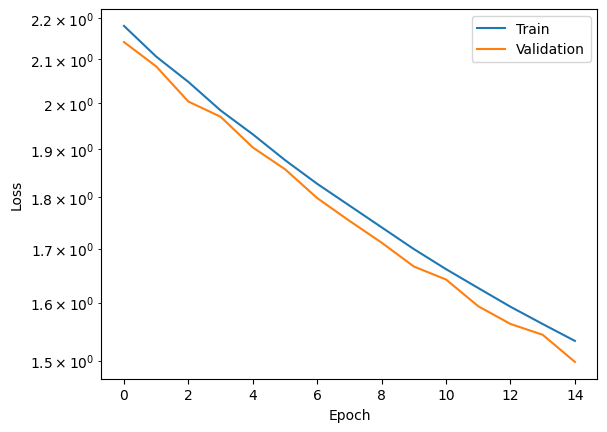

In [17]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

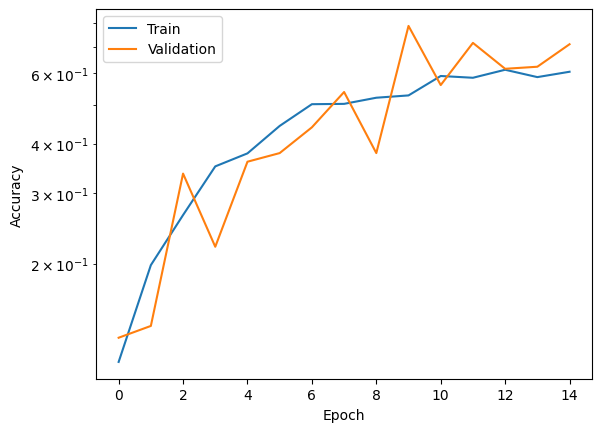

In [18]:
plt.semilogy(history.epoch, history.history['accuracy'], label='Train')
plt.semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
Y_train_pred =new_model.predict_generator(train_batches,train_steps)

In [20]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [21]:
print(len(train_batches.classes))
print(len(y_train_pred))

3161
3152


#### Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming train_batches is your training data generator
# Make predictions on the training set
y_train_pred = new_model.predict(train_batches, steps=train_batches.samples // train_batches.batch_size + 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Ensure the lengths match
assert len(train_batches.classes) == len(y_train_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)

print(cm_train)

# cm_train = confusion_matrix(train_batches.classes, y_train_pred)

198/198 [==============================] - 531s 3s/step
[[ 31   0 145  34   1  47  57  32   3]
 [ 34   0 128  28   3  44  77  37   2]
 [ 37   0 119  32   1  52  65  38  10]
 [ 39   0 130  37   0  44  59  36   3]
 [ 41   0 111  40   1  65  58  30   2]
 [ 36   0 118  25   3  56  68  45   1]
 [ 34   0 131  29   1  49  70  36   2]
 [ 34   0 116  35   2  46  73  46   2]
 [ 21   0 127  27   4  51  71  45   4]]


Text(0.5, 135.7222222222222, 'Predicted label')

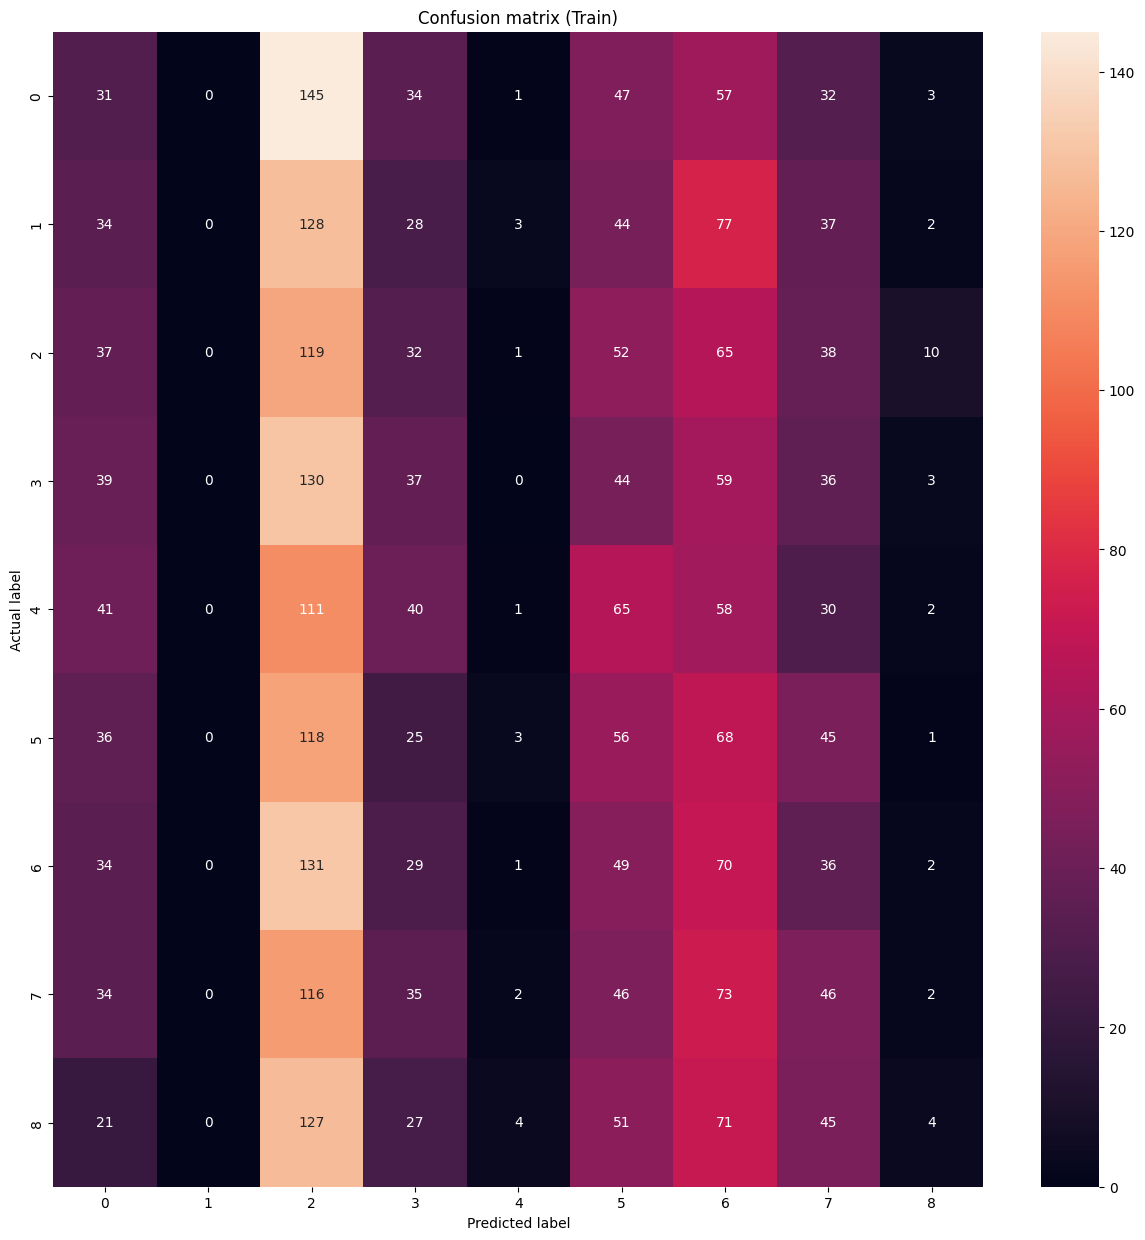

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [24]:
Y_pred =new_model.predict_generator(test_batches,test_steps)

In [25]:
y_pred = np.argmax(Y_pred, axis=1)

In [26]:
# cm = confusion_matrix(test_batches.classes, y_pred)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_batches is your test data generator
# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred_classes)

print(cm)

42/42 [==============================] - 70s 2s/step
[[ 6  0 24  7  0 15 14  6  1]
 [ 9  0 30  8  0  7 13  7  0]
 [10  0 27  4  0 11 11  9  1]
 [ 9  0 29  6  0  8 13  8  0]
 [ 3  0 27  8  1 12 13  8  0]
 [ 7  0 25  5  0 11 15 10  0]
 [ 6  0 27  8  0  8 17  7  0]
 [ 4  0 29  8  0 13 12  7  0]
 [ 9  0 23  3  0 14 11 12  1]]


Text(0.5, 135.7222222222222, 'Predicted label')

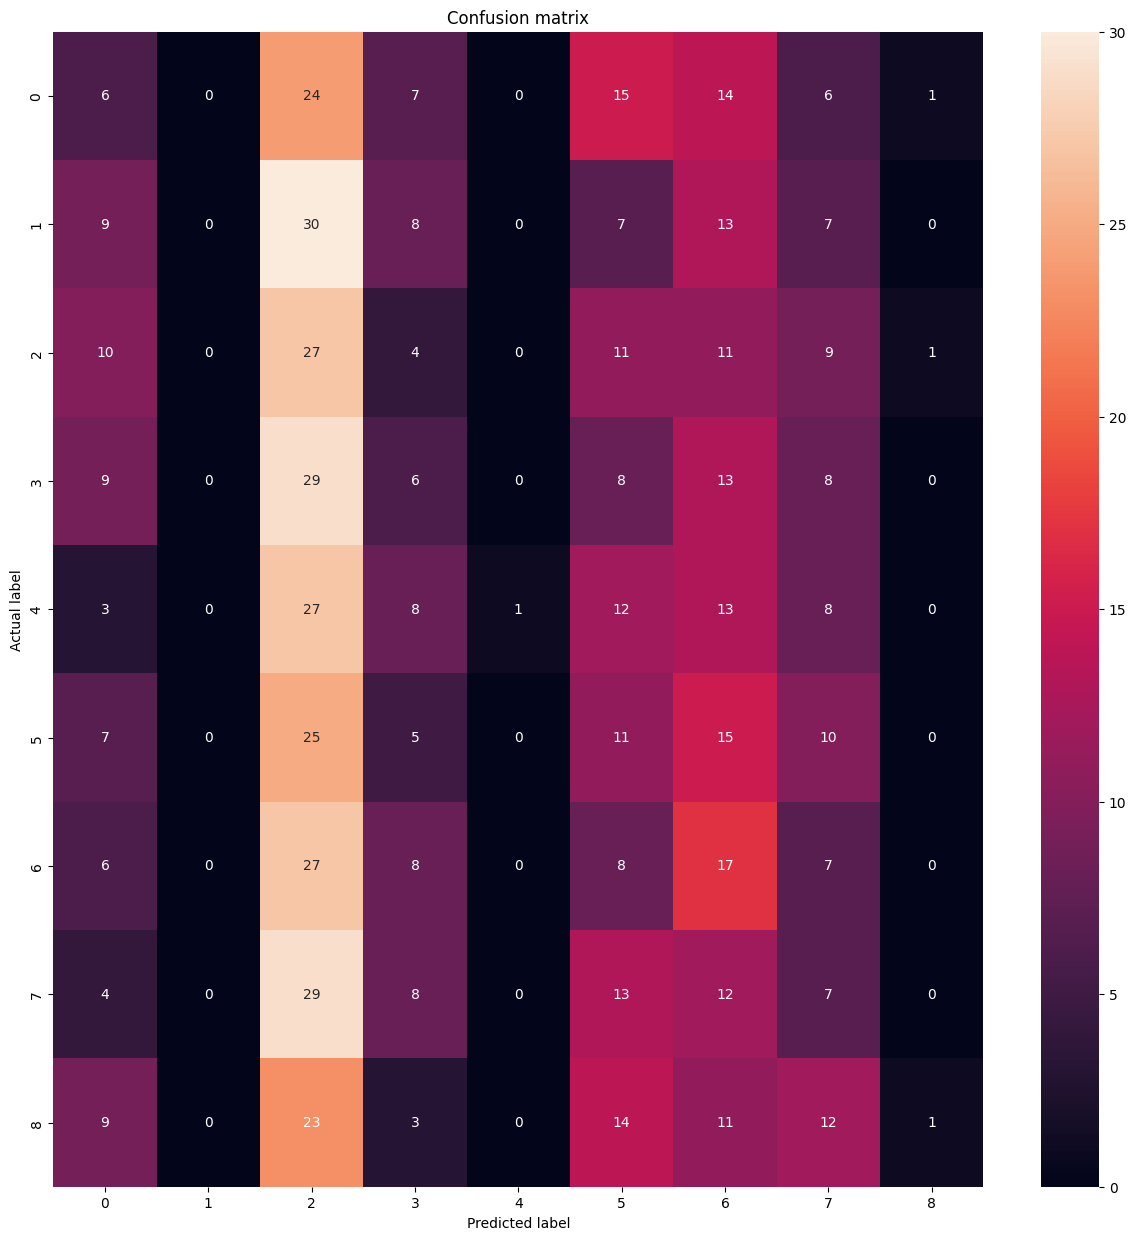

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Save model

In [28]:
new_model.save('vgg16_V1new.h5')